# Experimental data processing (fixing the baseline)

> 🎯 **Goal**: Clean the experimental data for the distance traveled by cells.
>
> ☑️ **Status**: Minor revisions ✨

---

## 💡 Context
The experimental data includes the distances traveled by cells over time. This distance is computed in regards to the cell monolayer at the top of the chip. Since the location of the monolayer is not always correctly detected through the image processing algorithm, the experimental results may appear inconsistent over distinct conditions. Thus, we will estimate the correct position of the initial fibroblast monolayer based  on the minimal traveled distance values and recompute the traveled distances in regards to this new baseline value.

In [7]:
from pathlib import Path
import pandas as pd
from scipy import io as sio
import seaborn as sns
import matplotlib.pyplot as plt

DATA_PATH = Path('raw-data/')
SAVE_PATH = Path('processed-data/')
FILE_STEM = 'multichip_data_'

## 2.5 mg/mL matrix - 96 hours
### Read the experimental data

In [61]:
def read_experimental_data(experimental_conditions):
    """Loads the experimental data stored in .mat files for a given set of conditions."""
    
    # Store data from all conditions in a dict
    data = {}

    for condition in experimental_conditions:
        # Load file
        mat_path = DATA_PATH / f'{FILE_STEM}{condition}.mat'
        mat_file = sio.loadmat(mat_path)
        distance_to_monolayer = mat_file['glob_dist2mono']

        # Format the data from four columns to two columns
        # One column will contain the distances and the other will contain the corresponding day
        distance_to_monolayer = pd.melt(pd.DataFrame(distance_to_monolayer))
        distance_to_monolayer.rename(columns={'variable': 'day', 'value': 'distance'},
                                     inplace=True)
        # Drop the NaN rows
        distance_to_monolayer = distance_to_monolayer.dropna()
        # Convert day column from 0 index notation
        distance_to_monolayer['day'] = distance_to_monolayer['day'] + 1
        distance_to_monolayer['distance'] = distance_to_monolayer['distance']
        distance_to_monolayer['condition'] = condition

        data[condition] = distance_to_monolayer
        
    data_df = pd.concat(data.values())

    return data_df


chemotaxis_conditions = ['control', 'cell_channel', 'opposite_channel']
conditions_labels = ['Control', 'Monolayer chamber', 'Opposite chamber']

chemotaxis_df = read_experimental_data(chemotaxis_conditions)
chemotaxis_df

,day,distance,condition
0,1,64.0,control
1,1,75.2,control
2,1,67.2,control
3,1,60.8,control
4,1,57.6,control
...,...,...,...
2855,4,97.6,opposite_channel
2856,4,110.4,opposite_channel
2857,4,153.6,opposite_channel
2858,4,422.4,opposite_channel


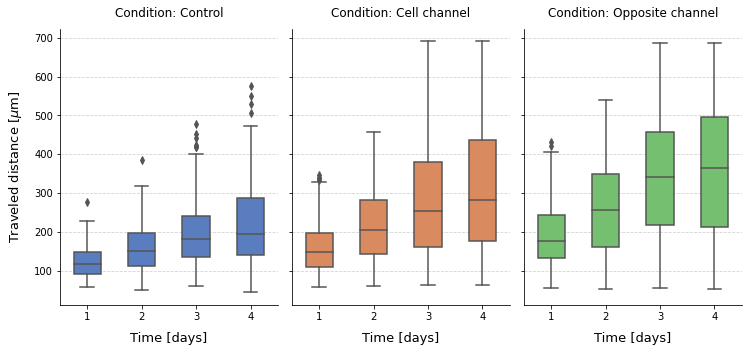

In [63]:
fig = sns.catplot(data=chemotaxis_df, x='day', y='distance', col='condition', hue='condition',
                  kind='box', width=0.5, aspect=0.7, dodge=False)

# Figure style
for ax, condition in zip(fig.axes.flatten(), ['Control', 'Cell channel', 'Opposite channel']):
    ax.set_title(f'Condition: {condition}', y=1.02)
    ax.set_axisbelow(True)
    ax.grid(axis='y', c='lightgrey', linestyle='dashed')
    
fig.set_xlabels('Time [days]', labelpad=10, fontsize=13)
fig.set_ylabels('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)
plt.tight_layout()

It appears that minimal traveled distance values are always around 50 microns. We can confirm this by looking into the average minimum value at each day.

In [64]:
# Select each condition and print info on minimum values
for condition in chemotaxis_conditions:
    condition_df = chemotaxis_df[chemotaxis_df['condition'] == condition]
    minimum_values = condition_df.groupby('day')['distance'].describe()['min']
    print(f'Condition: {condition}')
    print(f'Mean minimum value: {round(minimum_values.mean(), 2)}')
    print(f'Minimum value: {round(minimum_values.min(), 2)}')
    print()

Condition: control
Mean minimum value: 53.6
Minimum value: 44.8

Condition: cell_channel
Mean minimum value: 61.2
Minimum value: 59.2

Condition: opposite_channel
Mean minimum value: 54.8
Minimum value: 52.8



### Fix the baseline

We will use the average minimum traveled distance over the 4 days to locate the "real" location of the monolayer, assuming that some of the cells are still attached to this structure. Thus, we consider that the minimal distance values correspond to these cells, and, consequently, to the location of the monolayer. We will also assume that any distance value lower than 0 will be set to 0.

In [65]:
def fix_distance_baseline(data_df):
    """Computes new distance values based on the predicted monolayer location"""
    
    data_df['fixed_distance'] = np.NaN

    # Select each condition and print info on minimum values
    for condition in data_df.condition.unique():
        condition_indexes = list(data_df[data_df['condition'] == condition].index)
        condition_df = data_df.loc[condition_indexes]
        minimum_values = condition_df.groupby('day')['distance'].describe()['min']
        baseline_value = minimum_values.mean()
        data_df.loc[condition_indexes, 'fixed_distance'] = \
            data_df.loc[condition_indexes, 'distance'] - baseline_value

    data_df.loc[data_df['fixed_distance'] < 0, 'fixed_distance'] = 0
    
    return data_df

chemotaxis_df = fix_distance_baseline(chemotaxis_df)

# Rename the conditions to keep it consistent
chemotaxis_df['condition'] = chemotaxis_df['condition'].map({condition: label 
                                                            for condition, label
                                                            in zip(chemotaxis_conditions, conditions_labels)})

chemotaxis_df

,day,distance,condition,fixed_distance
0,1,64.0,Control,10.0
1,1,75.2,Control,21.2
2,1,67.2,Control,13.2
3,1,60.8,Control,6.8
4,1,57.6,Control,3.6
...,...,...,...,...
2855,4,97.6,Opposite chamber,43.6
2856,4,110.4,Opposite chamber,56.4
2857,4,153.6,Opposite chamber,99.6
2858,4,422.4,Opposite chamber,368.4


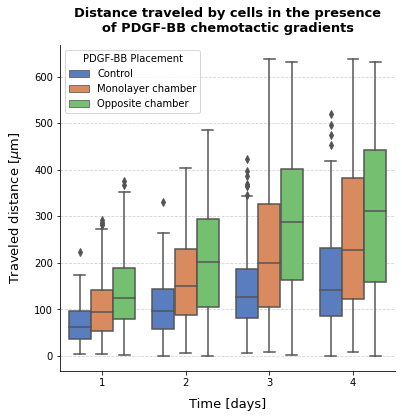

In [66]:
sns.set_palette('muted', 3)

fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=chemotaxis_df, x='day', y='fixed_distance', hue='condition', ax=ax)

# Figure style
ax.set_title(f'Distance traveled by cells in the presence\nof PDGF-BB chemotactic gradients', y=1.02, 
             fontsize=13, fontweight='bold')

ax.set_axisbelow(True)
ax.grid(axis='y', c='lightgrey', linestyle='dashed')

ax.set_xlabel('Time [days]', labelpad=10, fontsize=13)
ax.set_ylabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)

plt.legend(title='PDGF-BB Placement')
sns.despine()

### Save the data
Let's save this data in a CSV file for future use.

In [48]:
chemotaxis_df.to_csv(SAVE_PATH / '1chamber-96hours.csv', index=False)

We can now repeat this process for the remaining data: 2.5 mg/mL matrix - 216 hours, and 4.0 mg/mL matrix - 96 hours.

## 2.5 mg/mL matrix - 216 hours

In [88]:
# Read and fix data
chemotaxis_conditions = ['control_216h', 'factor_216h']
conditions_labels = ['Control', 'Opposite chamber']

chemotaxis_df = read_experimental_data(chemotaxis_conditions)
chemotaxis_df = fix_distance_baseline(chemotaxis_df)

# Fix the times at which the information was stored
convert_days = {old: new 
                for old, new in zip(range(1, 9), [0, 1, 2, 3, 4, 7, 8, 9])}  

chemotaxis_df['day'] = chemotaxis_df['day'].map(convert_days)
chemotaxis_df = chemotaxis_df[chemotaxis_df['day'] != 0]

# Rename conditions for consistency
chemotaxis_df['condition'] = chemotaxis_df['condition'].map({condition: label 
                                                            for condition, label
                                                            in zip(chemotaxis_conditions, conditions_labels)})

chemotaxis_df

,day,distance,condition,fixed_distance
301,1,72.45,Control,26.5650
302,1,66.01,Control,20.1250
303,1,59.57,Control,13.6850
304,1,59.57,Control,13.6850
305,1,66.01,Control,20.1250
...,...,...,...,...
6607,9,750.26,Opposite chamber,708.8025
6608,9,375.13,Opposite chamber,333.6725
6609,9,354.20,Opposite chamber,312.7425
6610,9,281.75,Opposite chamber,240.2925


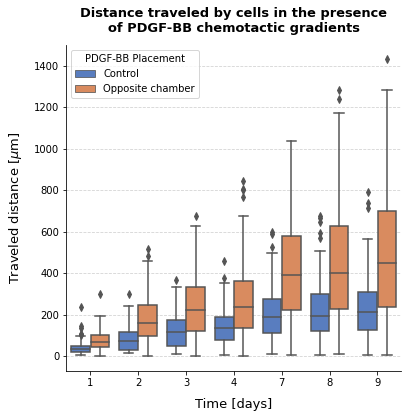

In [87]:
# Plot fixed distance results
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=chemotaxis_df, x='day', y='fixed_distance', hue='condition', ax=ax)

# Figure style
ax.set_title(f'Distance traveled by cells in the presence\nof PDGF-BB chemotactic gradients', y=1.02, 
             fontsize=13, fontweight='bold')

ax.set_axisbelow(True)
ax.grid(axis='y', c='lightgrey', linestyle='dashed')

ax.set_xlabel('Time [days]', labelpad=10, fontsize=13)
ax.set_ylabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)

plt.legend(title='PDGF-BB Placement')
sns.despine()

In [59]:
chemotaxis_df.to_csv(SAVE_PATH / '3ch-216hours.csv', index=False)

## 4 mg/mL matrix - 96 hours

In [89]:
# Read and fix data
chemotaxis_conditions = ['4mg_control', '4mg_factor']
conditions_labels = ['Control', 'Opposite channel']

chemotaxis_df = read_experimental_data(chemotaxis_conditions)
chemotaxis_df = fix_distance_baseline(chemotaxis_df)

# Rename conditions for consistency
chemotaxis_df['condition'] = chemotaxis_df['condition'].map({condition: label 
                                                            for condition, label
                                                            in zip(chemotaxis_conditions, conditions_labels)})

chemotaxis_df

,day,distance,condition,fixed_distance
0,1,144.90,Control,116.3225
1,1,180.32,Control,151.7425
2,1,111.09,Control,82.5125
3,1,78.89,Control,50.3125
4,1,67.62,Control,39.0425
...,...,...,...,...
3435,4,172.27,Opposite channel,143.6925
3436,4,218.96,Opposite channel,190.3825
3437,4,652.05,Opposite channel,623.4725
3438,4,635.95,Opposite channel,607.3725


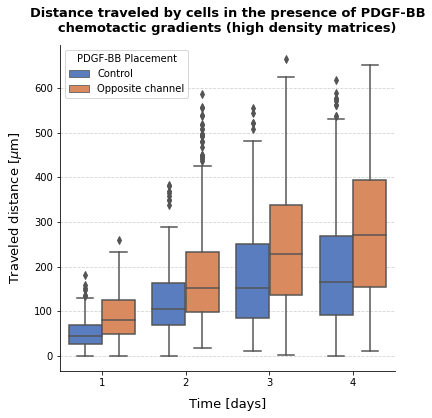

In [90]:
# Plot fixed distance results
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=chemotaxis_df, x='day', y='fixed_distance', hue='condition', ax=ax)

# Figure style

ax.set_axisbelow(True)
ax.grid(axis='y', c='lightgrey', linestyle='dashed')

ax.set_title(f'Distance traveled by cells in the presence of PDGF-BB\nchemotactic gradients (high density matrices)', y=1.02, 
             fontsize=13, fontweight='bold')
    
ax.set_xlabel('Time [days]', labelpad=10, fontsize=13)
ax.set_ylabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)

plt.legend(title='PDGF-BB Placement')

sns.despine()

In [78]:
chemotaxis_df.to_csv(SAVE_PATH / '4mgml-96hours.csv', index=False)